# Predect the next-year revenue by past-three-year ticket price, past-year win rate, past-year attention, and franchise name---with DNN

In [2]:
!ls data

Historical NBA Performance.xlsx NBA Team Annual Attendance.xlsx
NBA Finals and MVP.xlsx         NBA Tix Prices 1992-16.xls


In [172]:
import pandas as pd
import math
import numpy as np
from keras.utils import to_categorical
from keras.utils import *
from keras.models import Sequential, Input
from keras.layers import LSTM, Dense, Activation, Flatten, Dropout, Reshape, Bidirectional
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from keras import optimizers
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
import os
import collections
import seaborn as sns
import matplotlib.pyplot as plt
import pywt
from tqdm import tqdm_notebook as tqdm
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [82]:
win_rate  = pd.read_excel("data/Historical NBA Performance.xlsx", index=False)
attn = pd.read_excel("data/NBA Team Annual Attendance.xlsx", index=False)
price = pd.read_excel("data/NBA Tix Prices 1992-16.xls", index=False)

In [60]:
win_rate

,Year,Team,Record,Winning Percentage,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,2016-17,Celtics,25-15,0.625,NaN,NaN,NaN,NaN,NaN,NaT
1,2015-16,Celtics,48-34,0.585,NaN,NaN,NaN,NaN,NaN,NaT
2,2014-15,Celtics,40-42,0.488,NaN,NaN,NaN,NaN,NaN,NaT
3,2013-14,Celtics,25-57,0.305,NaN,NaN,NaN,NaN,NaN,NaT
4,2012-13,Celtics,41-40,0.506,NaN,NaN,NaN,NaN,NaN,NaT
5,2011-12 *,Celtics,39-27,0.591,NaN,NaN,NaN,NaN,NaN,NaT
6,2010-11-01 00:00:00,Celtics,56-26,0.683,NaN,NaN,NaN,NaN,NaN,NaT
7,2009-10-01 00:00:00,Celtics,50-32,0.610,NaN,NaN,NaN,NaN,NaN,NaT
8,2008-09-01 00:00:00,Celtics,62-20,0.756,NaN,NaN,NaN,NaN,NaN,NaT
9,2007-08-01 00:00:00,Celtics,66-16,0.805,NaN,NaN,NaN,NaN,NaN,NaT


# 資料處理函式
自己實作：
1. 隊伍名稱的one-hot encoding
2. 隊伍對應城市的對應陣列
3. 年份的字串切割與處理

In [158]:
def parse_year(str_year):
    return(str_year[0:4])
def encode_year(int_year):
    return str(int_year) + "-" + str(int_year + 1)[-2:]

city = ["Atlanta", "Boston", "Brooklyn", "Charlotte", "Chicago", "Cleveland", "Dallas", "Denver", "Detroit", 
            "Golden State", "Houston", "Indiana", "Los Angeles Clippers", "Los Angeles Lakers", "Memphis", "Miami", 
            "Milwaukee", "Minnesota", "New Jersey", "New Orleans", "New York", "Oklahoma City", "Orlando", 
            "Philadelphia", "Phoenix", "Portland", "Sacramento", "San Antonio", "Toronto", 
            "Utah", "Washington"]
team = ['Hawks', 'Celtics', 'Nets', 'Hornets', 'Bulls', 'Cavaliers', 'Mavericks', 'Nuggets', 'Pistons', 
            'Warriors', 'Rockets', 'Pacers', 'Clippers', 'Lakers', 'Grizzlies', 'Heat', 'Bucks', 
            'Timberwolves', 'Nets', 'Pelicans', 'NY Knicks', 'Thunder', 'Magic', '76ers', 'Suns',
            'Trail Blazers', 'Kings', 'Spurs', 'Raptors', 'Jazz', 'Wizards']

city2team = dict()
for i in range(len(city)):
    city2team[city[i]] = team[i]
onehot_team = dict()
for i in team:
    a = [0] * 31
    a[team.index(i)] = 1
    onehot_team[i] = a

In [115]:
attn

,Starting Year,Rank,Team,Home: Total Games,Home: Total Attendance,Home: Avg Attendance,Home: % Capactiy,Away: Total Games,Away: Total Attendance,Away: Avg Attendance,Away: % Capactiy
0,2015,1,Bulls,41,894659,21820,104.3,41,18156,94.5,82
1,2015,2,Cavaliers,41,843042,20562,100,41,18910,98.2,82
2,2015,3,Mavericks,41,825901,20143,104.9,41,17727,93.4,82
3,2015,4,Raptors,41,812863,19825,100.1,41,17162,89.2,82
4,2015,5,NY Knicks,41,812292,19812,100,41,18440,96,82
5,2015,6,Heat,41,809350,19740,100.7,41,18044,93.9,82
6,2015,7,Warriors,41,803436,19596,100,41,19134,100.5,82
7,2015,8,Trail Blazers,41,794085,19367,99.6,41,17703,93.3,82
8,2015,9,Jazz,41,791489,19304,97,41,17378,91.6,82
9,2015,10,Clippers,41,786910,19192,100.7,41,17792,93.6,82


In [128]:
attn_raw_data = dict()
for i in range(len(attn["Team"])):
    # print(encode_year(attn["Starting Year"][i]) + "/" + attn["Team"][i], attn["Home: Total Attendance"][i])
    attn_raw_data[encode_year(attn["Starting Year"][i]) + "/" + attn["Team"][i]] = attn["Home: Total Attendance"][i]

In [105]:
win_rate_raw_data = dict()
for i in range(len(win_rate["Winning Percentage"])):
    # print(win_rate["Team"][i], str(win_rate["Year"][i])[0:7])
    win_rate_raw_data[str(win_rate["Year"][i])[0:7] + "/" + win_rate["Team"][i]] = win_rate["Winning Percentage"][i]

In [106]:
win_rate_raw_data

{'2016-17/Celtics': 0.625,
 '2015-16/Celtics': 0.585,
 '2014-15/Celtics': 0.488,
 '2013-14/Celtics': 0.305,
 '2012-13/Celtics': 0.506,
 '2011-12/Celtics': 0.591,
 '2010-11/Celtics': 0.683,
 '2009-10/Celtics': 0.61,
 '2008-09/Celtics': 0.756,
 '2007-08/Celtics': 0.805,
 '2006-07/Celtics': 0.293,
 '2005-06/Celtics': 0.402,
 '2004-05/Celtics': 0.549,
 '2003-04/Celtics': 0.439,
 '2002-03/Celtics': 0.537,
 '2001-02/Celtics': 0.598,
 '2000-01/Celtics': 0.439,
 '1999-00/Celtics': 0.427,
 '1998-99/Celtics': 0.38,
 '1997-98/Celtics': 0.439,
 '1996-97/Celtics': 0.183,
 '1995-96/Celtics': 0.402,
 '1994-95/Celtics': 0.427,
 '1993-94/Celtics': 0.39,
 '1992-93/Celtics': 0.585,
 '1991-92/Celtics': 0.622,
 '1990-91/Celtics': 0.683,
 '1989-90/Celtics': 0.634,
 '1988-89/Celtics': 0.512,
 '1987-88/Celtics': 0.695,
 '1986-87/Celtics': 0.72,
 '1985-86/Celtics': 0.817,
 '1984-85/Celtics': 0.768,
 '1983-84/Celtics': 0.756,
 '1982-83/Celtics': 0.683,
 '1981-82/Celtics': 0.768,
 '1980-81/Celtics': 0.756,
 '197

# 資料清洗
這裡主要就是資料清洗，老實講寫的有點髒

In [132]:
team_price_dict = dict()
win_rate_dict = dict()
attn_dict = dict()
for i in price["Team"]:
    if(pd.isnull(i)):
        break
    elif(i == "Vancouver" or i == "Seattle"):
        continue
    team_price_dict[city2team[i]] = []
    win_rate_dict[city2team[i]] = []
    attn_dict[city2team[i]] = []
for i in price:
    if(i == "Team" or i == "%Avg"):
        continue
    for j in range(len(price[i])):
        if(price["Team"][j] == "Vancouver" or price["Team"][j] == "Seattle"):
            continue
        if(pd.isnull(price["Team"][j])):
            break
        if(city2team[price["Team"][j]] in team_price_dict.keys()):
            # print(price["Team"][j], price[i][j], i)
            if(pd.isnull(price[i][j])):
                # print(price[i][j])
                value = 0
            else:
                value = price[i][j]
            team_price_dict[city2team[price["Team"][j]]].append(value)
            if(i + "/" + city2team[price["Team"][j]] in win_rate_raw_data.keys()):
                win_rate_dict[city2team[price["Team"][j]]].append(win_rate_raw_data[i + "/" + city2team[price["Team"][j]]])
            else:
                win_rate_dict[city2team[price["Team"][j]]].append(0)
            if(i + "/" + city2team[price["Team"][j]] in attn_raw_data.keys()):
                attn_dict[city2team[price["Team"][j]]].append(attn_raw_data[i + "/" + city2team[price["Team"][j]]])
            else:
                attn_dict[city2team[price["Team"][j]]].append(0)

# 資料清洗完畢
以下的X每筆含有：前三年的票價、前一年的上座率、前一年的勝率、隊伍的one-hot encoding data。</br>

以下的每筆y則是：下一年的球隊revenue。

In [387]:
X = []
Y = []
for i in team_price_dict.keys():
    for j in range(len(team_price_dict[i])):
        temp = []
        if(j + 4 < len(team_price_dict[i]) - 1):
            # temp = temp + team_price_dict[i][j: j + 3]
            temp.append(team_price_dict[i][j + 4])
            temp.append(win_rate_dict[i][j])
            temp.append(attn_dict[i][j + 4])
            temp = temp + onehot_team[i]
            X.append(temp)
            Y.append(team_price_dict[i][j + 4] * attn_dict[i][j + 4])
X = np.array(X)
Y = np.array(Y)
Y.shape

(576,)

# DNN

In [383]:
def show_train_history(train_history, train, validation):
    # print(train_history.history[train], train_history.history[validation])
    plt.plot(train_history.history[train], label='Ein')
    plt.plot(train_history.history[validation], label = "Eout")
    plt.title("Train History")
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

In [388]:
# create model: DNN
model = Sequential()
# model.add(Dense(255, input_dim=X.shape[1], activation='relu'))
# Dropout(.5)
model.add(Dense(36, input_dim=X.shape[1], activation='relu'))
model.add(Dense(24, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [389]:
# Compile model
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
sgd = optimizers.SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_124 (Dense)            (None, 36)                144       
_________________________________________________________________
dense_125 (Dense)            (None, 24)                888       
_________________________________________________________________
dense_126 (Dense)            (None, 8)                 200       
_________________________________________________________________
dense_127 (Dense)            (None, 1)                 9         
Total params: 1,241
Trainable params: 1,241
Non-trainable params: 0
_________________________________________________________________


In [390]:
# Fit the model
ES = [EarlyStopping(monitor='val_loss', patience=20)]
MC = [ModelCheckpoint(filepath= './best_DNN_model.h5', monitor='loss', save_best_only=True)]

train_history = model.fit(X, Y, validation_split=0.2, epochs=100, callbacks=MC, batch_size=32, verbose = 1)

Train on 460 samples, validate on 116 samples
Epoch 1/100
460/460 [==============================] - 2s 5ms/step - loss: 8023.2870 - acc: 0.0000e+00 - val_loss: 8011.3300 - val_acc: 0.0000e+00
Epoch 2/100
460/460 [==============================] - 0s 137us/step - loss: 8004.5418 - acc: 0.0000e+00 - val_loss: 8000.5610 - val_acc: 0.0000e+00
Epoch 3/100
460/460 [==============================] - 0s 120us/step - loss: 7997.7455 - acc: 0.0000e+00 - val_loss: 7993.5117 - val_acc: 0.0000e+00
Epoch 4/100
460/460 [==============================] - 0s 130us/step - loss: 7989.2172 - acc: 0.0000e+00 - val_loss: 7983.1631 - val_acc: 0.0000e+00
Epoch 5/100
460/460 [==============================] - 0s 125us/step - loss: 7977.3894 - acc: 0.0000e+00 - val_loss: 7969.6665 - val_acc: 0.0000e+00
Epoch 6/100
460/460 [==============================] - 0s 124us/step - loss: 7962.6376 - acc: 0.0000e+00 - val_loss: 7953.8222 - val_acc: 0.0000e+00
Epoch 7/100
460/460 [==============================] - 0s 128u

460/460 [==============================] - 0s 117us/step - loss: 7921.0367 - acc: 0.0000e+00 - val_loss: 7921.0352 - val_acc: 0.0000e+00
Epoch 56/100
460/460 [==============================] - 0s 148us/step - loss: 7921.0352 - acc: 0.0000e+00 - val_loss: 7921.0342 - val_acc: 0.0000e+00
Epoch 57/100
460/460 [==============================] - 0s 205us/step - loss: 7921.0342 - acc: 0.0000e+00 - val_loss: 7921.0327 - val_acc: 0.0000e+00
Epoch 58/100
460/460 [==============================] - 0s 117us/step - loss: 7921.0327 - acc: 0.0000e+00 - val_loss: 7921.0327 - val_acc: 0.0000e+00
Epoch 59/100
460/460 [==============================] - 0s 120us/step - loss: 7921.0315 - acc: 0.0000e+00 - val_loss: 7921.0312 - val_acc: 0.0000e+00
Epoch 60/100
460/460 [==============================] - 0s 125us/step - loss: 7921.0303 - acc: 0.0000e+00 - val_loss: 7921.0298 - val_acc: 0.0000e+00
Epoch 61/100
460/460 [==============================] - 0s 190us/step - loss: 7921.0293 - acc: 0.0000e+00 - val_l

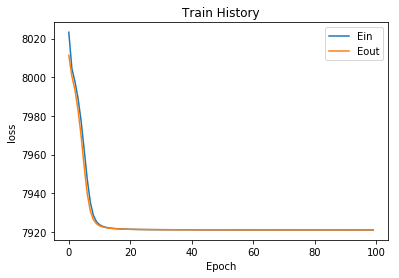

In [391]:
show_train_history(train_history, 'loss', 'val_loss')
model.save('./DNN_model.h5')

In [ ]:
# evaluate the model
scores = model.evaluate(X, Y)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))